<a href="https://colab.research.google.com/github/fabianlae/Predict-H1N1-and-Seasonal-Flu-Vaccines/blob/main/Flushot_Entscheidungsbaum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Daten einlesen

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 100) # Display more dataframe columns in Jupyter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Root directory for my (Fabian) Google Drive 
root_dir = '/content/drive/MyDrive/Flu_challenge/Predict-H1N1-and-Seasonal-Flu-Vaccines/data/raw/'

features_df = pd.read_csv(
    root_dir + 'training_set_features.csv', 
    index_col="respondent_id"
)
labels_df = pd.read_csv(
    root_dir + 'training_set_labels.csv', 
    index_col="respondent_id"
)

In [ ]:
print("features_df.shape", features_df.shape)
features_df.head()

features_df.shape (26707, 35)


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [ ]:
features_df.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty           

In [ ]:
print("labels_df.shape", labels_df.shape)
labels_df.head()

labels_df.shape (26707, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


In [ ]:

np.testing.assert_array_equal(features_df.index.values, labels_df.index.values)

# Daten verstehen

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

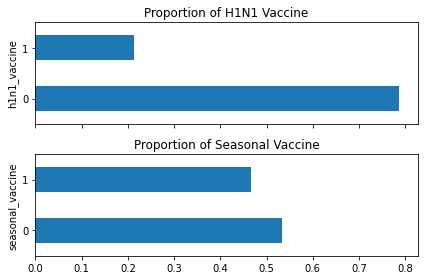

In [ ]:
fig, ax = plt.subplots(2, 1, sharex=True)

n_obs = labels_df.shape[0]

(labels_df['h1n1_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of H1N1 Vaccine", ax=ax[0])
)
ax[0].set_ylabel("h1n1_vaccine")

(labels_df['seasonal_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of Seasonal Vaccine", ax=ax[1])
)
ax[1].set_ylabel("seasonal_vaccine")

fig.tight_layout()

In [ ]:
pd.crosstab(
    labels_df["h1n1_vaccine"], 
    labels_df["seasonal_vaccine"], 
    margins=True,
    normalize=True
)

seasonal_vaccine,0,1,All
h1n1_vaccine,,,
0,0.497810,0.289737,0.787546
1,0.036582,0.175871,0.212454
All,0.534392,0.465608,1.000000


In [ ]:
joined_df = features_df.join(labels_df)
counts = (joined_df[['h1n1_concern', 'h1n1_vaccine']]
              .groupby(['h1n1_concern', 'h1n1_vaccine'])
              .size()
              .unstack('h1n1_vaccine')
         )
counts

h1n1_vaccine,0,1
h1n1_concern,,
0.0,2849,447
1.0,6756,1397
2.0,8102,2473
3.0,3250,1341


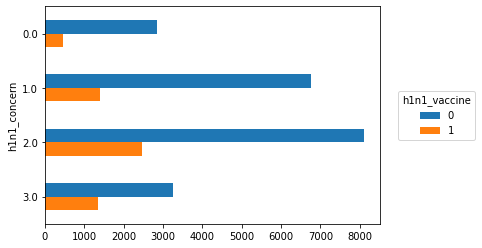

In [ ]:
# To plot h1n1_vaccine as a separate series, 
# we pivot using unstack to make h1n1_vaccine into columns 
ax = counts.plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='h1n1_vaccine'
)

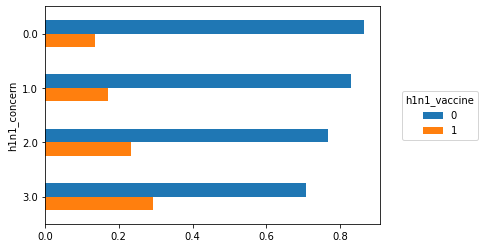

In [ ]:
h1n1_concern_counts = counts.sum(axis='columns')
props = counts.div(h1n1_concern_counts, axis='index')
ax = props.plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    title='h1n1_vaccine'
)

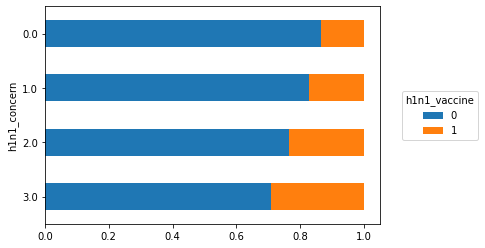

In [ ]:
ax = props.plot.barh(stacked=True)
ax.invert_yaxis()
ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    title='h1n1_vaccine'
)

In [ ]:
def vaccination_rate_plot(col, target, data, ax=None):
    """Stacked bar chart of vaccination rate for `target` against 
    `col`. 
    
    Args:
        col (string): column name of feature variable
        target (string): column name of target variable
        data (pandas DataFrame): dataframe that contains columns 
            `col` and `target`
        ax (matplotlib axes object, optional): matplotlib axes 
            object to attach plot to
    """
    counts = (joined_df[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()

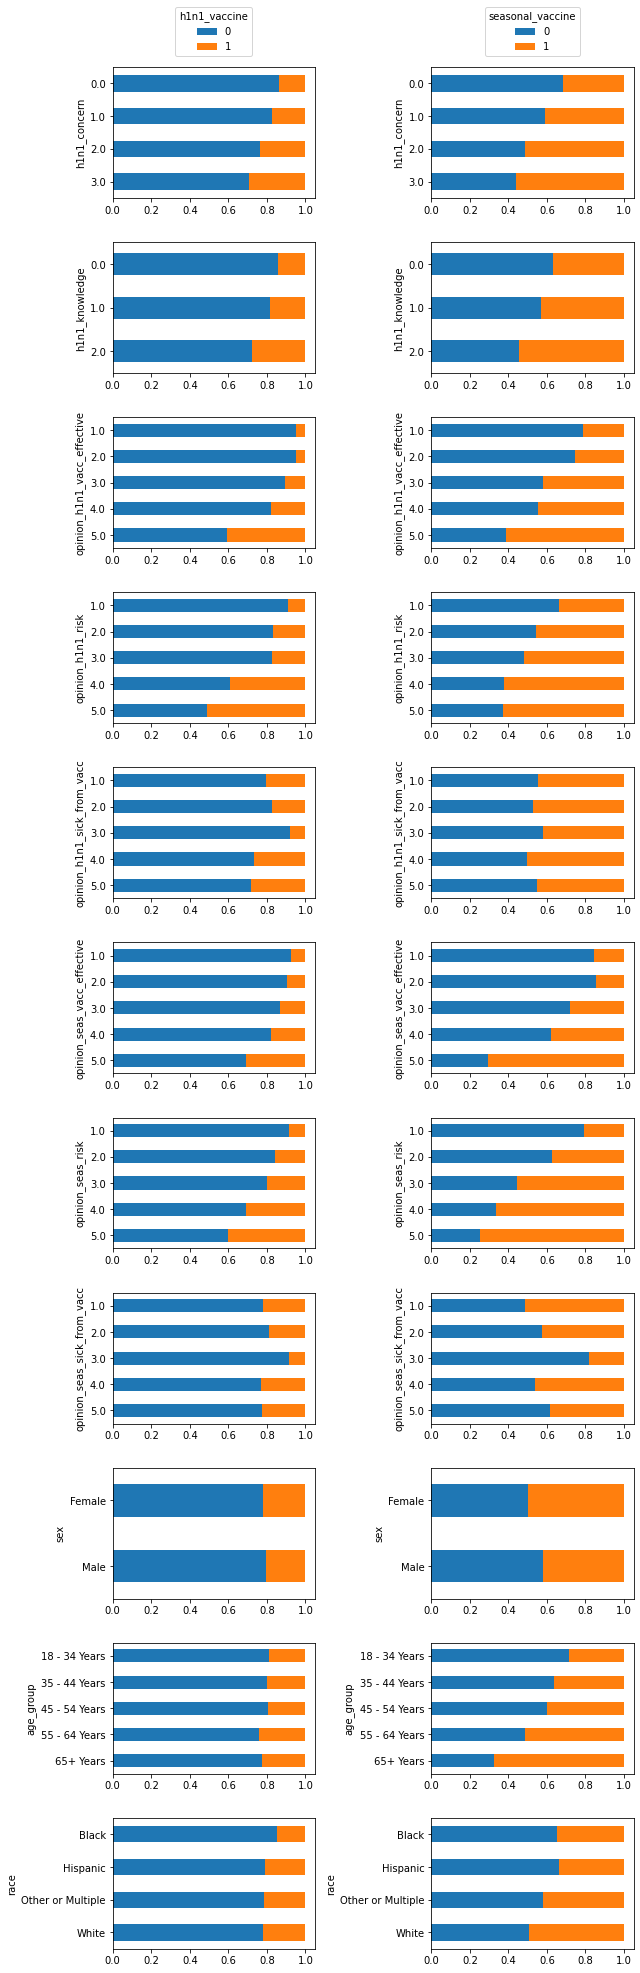

In [ ]:
cols_to_plot = [
    'h1n1_concern',
    'h1n1_knowledge',
    'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc',
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc',
    'sex',
    'age_group',
    'race',
]

fig, ax = plt.subplots(len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5))
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(col, 'h1n1_vaccine', joined_df, ax=ax[idx, 0])
    vaccination_rate_plot(col, 'seasonal_vaccine', joined_df, ax=ax[idx, 1])
    
ax[0, 0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine')
ax[0, 1].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine')
fig.tight_layout()

# Analytics



## Preprocessing

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, roc_auc_score

RANDOM_SEED = 6    # Set a random seed for reproducibility!

In [ ]:
numeric_cols = features_df.columns[features_df.dtypes != "object"].values
print(numeric_cols)

['h1n1_concern' 'h1n1_knowledge' 'behavioral_antiviral_meds'
 'behavioral_avoidance' 'behavioral_face_mask' 'behavioral_wash_hands'
 'behavioral_large_gatherings' 'behavioral_outside_home'
 'behavioral_touch_face' 'doctor_recc_h1n1' 'doctor_recc_seasonal'
 'chronic_med_condition' 'child_under_6_months' 'health_worker'
 'health_insurance' 'opinion_h1n1_vacc_effective' 'opinion_h1n1_risk'
 'opinion_h1n1_sick_from_vacc' 'opinion_seas_vacc_effective'
 'opinion_seas_risk' 'opinion_seas_sick_from_vacc' 'household_adults'
 'household_children']


In [ ]:
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='median'))
])

# create the preprocessor stage of final pipeline
# each entry in the transformer list is a tuple of
# (name you choose, sklearn transformer, list of columns)
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols)
    ],
    remainder = "drop"
)

## SVM (First Try)

In [ ]:
numeric_cols = features_df.columns[features_df.dtypes != "object"].values
num_features_df = features_df[numeric_cols]

In [ ]:
from sklearn import svm

In [ ]:
h1n1_label = np.asarray(labels_df['h1n1_vaccine'])

5674

In [ ]:
rows = []
for index, row in num_features_df.iterrows():
  rows.append(row.to_numpy(dtype=int))

num_features_array = np.asarray(rows)

In [ ]:
clf = svm.SVC()
clf.fit(num_features_array, h1n1_label)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
test_features = pd.read_csv(
    root_dir + 'test_set_features.csv', 
    index_col="respondent_id"
)
test_features.iloc[0].to_numpy(dtype=int)

ValueError: ignored

## Training

In [ ]:
estimators = MultiOutputClassifier(
    estimator=RandomForestRegressor()
)

In [ ]:
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])

In [ ]:
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.33,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)

In [ ]:
%%time

# Train model
full_pipeline.fit(X_train, y_train)

# Predict on evaluation set
# This competition wants probabilities, not labels
preds = full_pipeline.predict_proba(X_eval)
preds

AttributeError: ignored

In [ ]:
print("test_probas[0].shape", preds[0].shape)
print("test_probas[1].shape", preds[1].shape)

test_probas[0].shape (8814, 2)
test_probas[1].shape (8814, 2)


In [ ]:
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_eval.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (8814, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
6728,0.291010,0.472780
16516,0.097770,0.381615
3106,0.155402,0.629756
16981,0.661791,0.857876
19111,0.284478,0.776927


In [ ]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

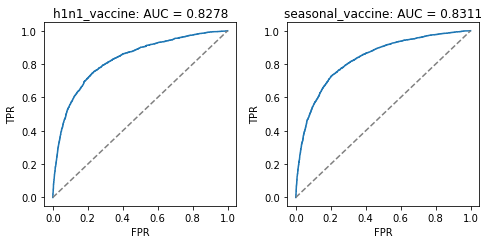

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_eval['h1n1_vaccine'], 
    y_preds['h1n1_vaccine'], 
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_eval['seasonal_vaccine'], 
    y_preds['seasonal_vaccine'], 
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

In [ ]:
roc_auc_score(y_eval, y_preds)

0.8294712007285718